![](https://cdn.icon-icons.com/icons2/2699/PNG/512/pytorch_logo_icon_169823.png)

A deep learning neural network learns to map a set of inputs to a set of outputs from training data.

We cannot calculate the perfect weights for a neural network; there are too many unknowns. Instead, the problem of learning is cast as a search or optimization problem and an algorithm is used to navigate the space of possible sets of weights the model may use in order to make good or good enough predictions.

Typically, a neural network model is trained using the stochastic gradient descent optimization algorithm and weights are updated using the backpropagation of error algorithm.

The “gradient” in gradient descent refers to an error gradient. The model with a given set of weights is used to make predictions and the error for those predictions is calculated.

The gradient descent algorithm seeks to change the weights so that the next evaluation reduces the error, meaning the optimization algorithm is navigating down the gradient (or slope) of error.

Now that we know that training neural nets solves an optimization problem, we can look at how the error of a given set of weights is calculated.

In [5]:
import torch
from torch import nn # basic building blocks
from torch import optim # optimization algorithms
from torchvision import datasets, transforms # get mnist dataset and transform to tensor
from torch.utils.data import random_split, DataLoader # basically train_test_split and batching
torch.manual_seed(42) # Set pytorch pseudo-random generator at a fixed value

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Load the data

The MNIST database (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used for training various image processing systems. The MNIST database contains 60,000 training images and 10,000 testing images.

In [7]:
train_data = datasets.MNIST(
    root='data', 
    train=True, 
    download=True, 
    transform=transforms.ToTensor()
)

test_data = datasets.MNIST(
    root='data', 
    train=False, 
    transform=transforms.ToTensor()
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [8]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [9]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [10]:
train_data.data.size()

torch.Size([60000, 28, 28])

In [11]:
test_data.data.size()

torch.Size([10000, 28, 28])

### Visualize the data

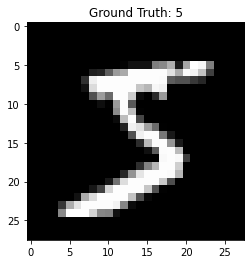

In [17]:
import matplotlib.pyplot as plt

plt.imshow(train_data.data[0], cmap='gray')
plt.title('Ground Truth: %i' % train_data.targets[0])
plt.show()

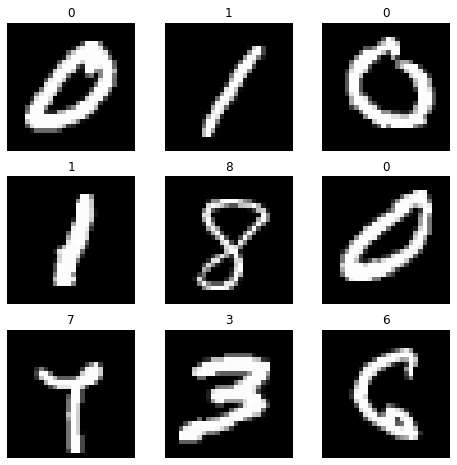

In [25]:
figure = plt.figure(figsize=(8, 8))
rows, cols = 3, 3

for i in range(1, rows * cols + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title('%i' % label)
    plt.axis('off')
    plt.imshow(img.squeeze(), cmap='gray')

plt.show()

### Train Test Split
While training a model, we typically want to pass samples in “minibatches”, reshuffle the data at every epoch to reduce model overfitting, and use Python’s multiprocessing to speed up data retrieval.

In [26]:
BATCH_SIZE = 32

train, val = random_split(train_data, [50000, 10000])
train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val, batch_size=BATCH_SIZE, shuffle=True)

test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

### Defining a model

* [**`nn.Sequential()`**](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html#torch.nn.Sequential): a sequential container where modules will be added to it in the order they are passed in the constructor.
* [**`nn.Linear()`**](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html): applies a linear transformation to the incoming data.
* [**`nn.ReLU()`**](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU): applies the rectified linear unit function element-wise. This is done to add non-linearity to the model.
* [**`nn.Dropout()`**](https://pytorch.org/docs/1.9.0/generated/torch.nn.Dropout.html?highlight=dropout#torch.nn.Dropout): during training, randomly zeroes some of the elements of the input tensor.

In [27]:
model = nn.Sequential(
    nn.Linear(28 * 28, 64), # 28x28 images, 64 neurons in 1st hidden layer
    nn.ReLU(), # non linear
    nn.Linear(64, 64), # from 64 neurons in hidden layer to another 64
    nn.ReLU(),
    nn.Dropout(0.1), # if we're overfitting, we can set 0.1 neurons to zero
    nn.Linear(64, 10) # from 64 to 10 (mnist has 10 classess)
)

We can allow the optimizer to skip the second hidden layer or skip a few hidden units if it's not necessary. Now, we can try to define the more flexible model (residual connections).

In [28]:
class ResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(28 * 28, 64)
        self.l2 = nn.Linear(64, 64)
        self.l3 = nn.Linear(64, 10)
        self.do = nn.Dropout(0.1)

    def forward(self, x):
        h1 = nn.functional.relu(self.l1(x))
        h2 = nn.functional.relu(self.l2(h1))

        # if h2 is not necessary, network can set the bias to negative
        # such that relu will set it to zero.
        do = self.do(h2 + h1) 

        logits = self.l3(do)
        return logits

### Optimizer

Optimizers are algorithms used to minimize the loss function. It is dependent on model’s learnable parameters i.e weights and biases. Optimizers help to know how to change weights and learning rate of neural network to reduce the losses.

In [29]:
params = model.parameters()
optimizer = optim.SGD(params, lr=1e-2) # stochastic gradient descent

### Loss Function

Loss function has an important job in that it must faithfully distill all aspects of the model down into a single number in such a way that improvements in that number are a sign of a better model. If we choose a loss error function and obtain unsatisfactory results, the fault is ours for badly specifying the goal of the search.

In [30]:
# how do we want to change the parameters on the model
loss = nn.CrossEntropyLoss() # useful when training a classification problem with C classes

### Training and validation loops

First, let's try using the base model then we can compare it with the residual networks.

In [31]:
nb_epochs = 5 # how many we times we go through the dataset

for epoch in range(nb_epochs): # for each pass through the whole dataset,
    losses = list() # store the loss
    accuracies = list() # store the accuracy

    # .train() # tells the model that you are training the model. 
    # So effectively layers like dropout, batchnorm etc. which behave different
    # on the train and test procedures know what is going on and hence can behave accordingly.
    # example: during inference mode, dropout will be deactivated
    model.train() 

    for batch in train_loader: # we are gonna get the batch from the loader
        x, y = batch # get the input (image) and label (class) from the batch
        
        # x: batch size * channel (1) * 28 * 28
        b = x.size(0) # returns 1st dimension of the tensor (which is the batch size, this should remain the constant)

        # .view() reshapes the tensor of the specified shape
        # In this case, we flatten the tensor, because the Linear layer only accepts vector (1d array)
        # -1 in x.view() is a filler, in other words, its dimensions that we don't know, so PyTorch automatically calculates it
        # For example, if x = torch.tensor([1,2,3,4]), to reshape the tensor to a 2x2, you could do x.view(2,2) or x.view(2,-1) or x.view(-1,2)
        x = x.view(b, -1) # in this case, -1 equals 28*28

        # now we have a big matrix with b rows (because we have the first size b) 
        # and the columns (length of each row) will be 1 * 28 * 28 

        # 1. forward step
        l = model(x) # logits (predictions which come out from the last layer of the nn)

        # 2. compute objective function (how well the model is)
        # The function we want to minimize or maximize is called the objective 
        # function or criterion. When we are minimizing it, we may also call it 
        # the cost function, loss function, or error function.
        J = loss(l, y) # logits, label

        # 3. cleaning the gradients from the previous step
        model.zero_grad() # params.grad.zero_() OR optim.zero_grad()

        # 4. accumulate the partial dertivatives of J with respect to the parameters
        J.backward() # params.grad.add_(dJ/dparams)

        # 5. step in the opposite direction of the gradient
        optimizer.step() # with torch.no_grad(): params = params - eta * params.grad (manual update)

        losses.append(J.item())

        # get highest probability and compute the mean of accuracy
        accuracies.append(y.eq(l.detach().argmax(dim=1)).float().mean()) 

    print(f'Epoch {epoch + 1}', end=', ')
    print(f'train loss: {torch.tensor(losses).mean():.2f}', end=', ')
    print(f'train accuracy: {torch.tensor(accuracies).mean():.2f}')

    # validation step
    losses = list() 
    accuracies = list()
    model.eval() # inference mode
    for batch in val_loader:
        x, y = batch 
        b = x.size(0) 
        x = x.view(b, -1)

        # 1. forward step
        with torch.no_grad(): # compute without gradients
            l = model(x) # logits

        # 2. compute objective function (how well the model is)
        J = loss(l, y) # logits, label

        losses.append(J.item())
        accuracies.append(y.eq(l.detach().argmax(dim=1)).float().mean()) 
    
    print(f'Epoch {epoch + 1}', end=', ')
    print(f'validation loss: {torch.tensor(losses).mean():.2f}', end=', ')
    print(f'validation accuracy: {torch.tensor(accuracies).mean():.2f}')

Epoch 1, train loss: 1.29, train accuracy: 0.65
Epoch 1, validation loss: 0.50, validation accuracy: 0.86
Epoch 2, train loss: 0.46, train accuracy: 0.87
Epoch 2, validation loss: 0.37, validation accuracy: 0.89
Epoch 3, train loss: 0.38, train accuracy: 0.89
Epoch 3, validation loss: 0.31, validation accuracy: 0.91
Epoch 4, train loss: 0.33, train accuracy: 0.91
Epoch 4, validation loss: 0.28, validation accuracy: 0.92
Epoch 5, train loss: 0.30, train accuracy: 0.92
Epoch 5, validation loss: 0.25, validation accuracy: 0.93


In [32]:
l.detach()[0]

tensor([-0.8515, -0.1444,  0.9439,  3.0667, -3.2735,  0.4422, -3.5934,  4.7685,
        -0.6341,  0.9499])

In [33]:
l.detach()[0].argmax()

tensor(7)

In [34]:
l.detach()[0].softmax(dim=0)

tensor([2.8872e-03, 5.8557e-03, 1.7386e-02, 1.4525e-01, 2.5623e-04, 1.0528e-02,
        1.8608e-04, 7.9657e-01, 3.5883e-03, 1.7492e-02])

In [35]:
for idx, proba in enumerate(l.detach()[0].softmax(dim=0)):
    print(idx, proba)

0 tensor(0.0029)
1 tensor(0.0059)
2 tensor(0.0174)
3 tensor(0.1453)
4 tensor(0.0003)
5 tensor(0.0105)
6 tensor(0.0002)
7 tensor(0.7966)
8 tensor(0.0036)
9 tensor(0.0175)


Now, let's try the residual networks.

In [36]:
my_resnet_model = ResNet().cuda() # with GPU
my_resnet_model

ResNet(
  (l1): Linear(in_features=784, out_features=64, bias=True)
  (l2): Linear(in_features=64, out_features=64, bias=True)
  (l3): Linear(in_features=64, out_features=10, bias=True)
  (do): Dropout(p=0.1, inplace=False)
)

In [37]:
nb_epochs = 5 # how many we times we go through the dataset
params = my_resnet_model.parameters() # using the residual networks
optimizer = optim.SGD(params, lr=1e-2) # stochastic gradient descent
loss = nn.CrossEntropyLoss() 

for epoch in range(nb_epochs): # for each pass through the whole dataset,
    losses = list() # store the loss
    accuracies = list() # store the accuracy
    my_resnet_model.train() # training mode

    for batch in train_loader: 
        # send both x and y to cuda
        x, y = batch
        b = x.size(0) 
        x = x.view(b, -1).cuda()
        l = my_resnet_model(x) # forward propagation
        J = loss(l, y.cuda()) # compute objective function
        my_resnet_model.zero_grad() # cleaning the gradients
        J.backward() # accumulate the partial dertivatives
        optimizer.step() # step in the opposite direction of the gradient
        losses.append(J.item())
        accuracies.append(y.eq(l.detach().argmax(dim=1).cpu()).float().mean()) 

    print(f'Epoch {epoch + 1}', end=', ')
    print(f'train loss: {torch.tensor(losses).mean():.2f}', end=', ')
    print(f'train accuracy: {torch.tensor(accuracies).mean():.2f}')

    # validation step
    losses = list() 
    accuracies = list()
    my_resnet_model.eval() # inference mode
    for batch in val_loader:
        x, y = batch 
        b = x.size(0) 
        x = x.view(b, -1).cuda()

        with torch.no_grad(): # compute without gradients
            l = my_resnet_model(x) # logits

        J = loss(l, y.cuda()) # logits, label

        losses.append(J.item())
        accuracies.append(y.eq(l.detach().argmax(dim=1).cpu()).float().mean()) 
    
    print(f'Epoch {epoch + 1}', end=', ')
    print(f'validation loss: {torch.tensor(losses).mean():.2f}', end=', ')
    print(f'validation accuracy: {torch.tensor(accuracies).mean():.2f}')

Epoch 1, train loss: 0.88, train accuracy: 0.78
Epoch 1, validation loss: 0.39, validation accuracy: 0.89
Epoch 2, train loss: 0.38, train accuracy: 0.89
Epoch 2, validation loss: 0.30, validation accuracy: 0.91
Epoch 3, train loss: 0.31, train accuracy: 0.91
Epoch 3, validation loss: 0.26, validation accuracy: 0.93
Epoch 4, train loss: 0.27, train accuracy: 0.92
Epoch 4, validation loss: 0.23, validation accuracy: 0.93
Epoch 5, train loss: 0.24, train accuracy: 0.93
Epoch 5, validation loss: 0.21, validation accuracy: 0.94


### Predict on unseen data

In [39]:
losses = list() 
accuracies = list()
my_resnet_model.eval() # inference mode

for batch in test_loader:
    x, y = batch
    b = x.size(0) 
    x = x.view(b, -1).cuda()

    with torch.no_grad(): # compute without gradients
        l = my_resnet_model(x) # logits

    J = loss(l, y.cuda()) # logits, label

    losses.append(J.item())
    accuracies.append(y.eq(l.detach().argmax(dim=1).cpu()).float().mean()) 

print(f'testing loss: {torch.tensor(losses).mean():.2f}', end=', ')
print(f'testing accuracy: {torch.tensor(accuracies).mean():.2f}')

testing loss: 0.20, testing accuracy: 0.94


### Saving the model

In [40]:
torch.save(my_resnet_model, './my_resnet_model.pt') 